## Machine Learning
### Assignment 1

*27 January, 2017*  
*Georgios Pastakas*

#### Group Assignment: Predicting Wine Quality with k-Nearest Neighbours

In this assignment we will use the data file [wine_quality-red.csv](http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/) which contains red variants of the Portuguese "Vinho Verde" wine. More information on the dataset can be found [here](http://archive.ics.uci.edu/ml/datasets/Wine+Quality).

In [344]:
%matplotlib inline

import itertools
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [113]:
# Load dataset
red_wine = pd.read_csv("winequality-red.csv", sep = ";")

# Construct a new binary column “good wine” that indicates whether the wine is good 
# which we define as having a quality of 6 or higher or not
red_wine["good wine"] = np.array(red_wine["quality"] > 5, dtype = int)

red_wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [114]:
# Split dataset randomly into training and test dataset (~50% each) 
train, test = train_test_split(red_wine, test_size = 0.5, random_state = 1)

# Reset indices of each dataset
train, test = train.reset_index(drop = True), test.reset_index(drop = True)

In [115]:
# List with original variables of the dataet
original_feats = red_wine.columns.values[:-1]

# Normalise the training and test dataset separately according to the Z-score transform
# We don't normalise "quality" and "good wine" variables as they are categorical and ordinal respectively

# P.S. We could either normalise all the dataset before splitting it based on one common mu and sigma, 
# or use the mu and sigma of the training set to normalise the test set (in case the test set is small)

for feat in original_feats[:-1]:
    train[feat + " norm"] = stats.zscore(train.loc[:, feat])
    test[feat + " norm"] = stats.zscore(test.loc[:, feat])

# List with both the original and artificial variables of the dataset
all_feats = train.columns.values

In [229]:
# Split the trainning dataset in a matrix with the predictor vairables and
# an array with the target value

# Target variable is "good wine"
# To train the model we will use the normalised variables
X_train, y_train = train[all_feats[13:]], train["good wine"]

valid_error, train_error = {}, {}

# Load and train the k-Nearest Neighbours classifiers for k = 1, 6, 11, 16, ..., 501
# Evaluate each classifier using 5-fold cross validation
for k in range(1, 502, 5):
    kNClass = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    valid_error[k] = 1 - np.mean(cross_val_score(kNClass, X_train, y_train, cv = 5))
    train_error[k] = 1 - kNClass.score(X_train, y_train)
    
evalu = pd.merge(pd.DataFrame(sorted(list(valid_error.items())), columns = ["k", "valid_error"]), \
                 pd.DataFrame(sorted(list(train_error.items())), columns = ["k", "train_error"]), on = "k")

In [452]:
# Select the # neighbours that resulted in the best classifier
k_min = evalu[evalu["valid_error"] == min(evalu["valid_error"])].values[0][0]

# Train the k-Nearest Neighbours classifiers for k = k_min
kNClass_max = KNeighborsClassifier(n_neighbors = k_min).fit(X_train, y_train)

# Target variable is "good wine"
# To train the model we will use the normalised variables
X_test, y_test = test[all_feats[13:]], test["good wine"]

# Predict generalisation error using test dataset
ge = 1 - kNClass.score(X_test, y_test)

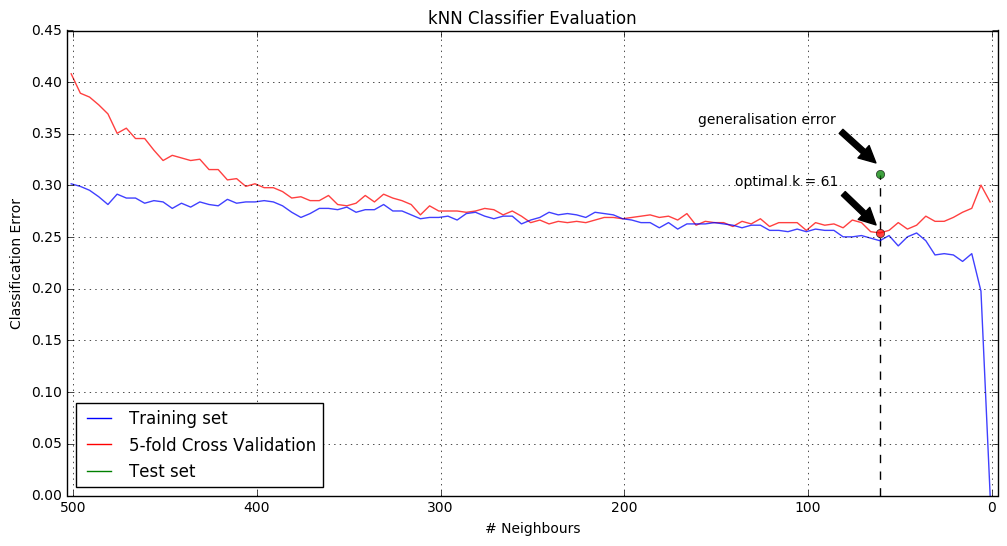

In [459]:
# Plot results
plt.figure(figsize = (12, 6))

plt.axvline(x = k_min, ymin = 0, ymax = 1 - ge, ls = "--", linewidth =  1, color = "k")
plt.plot(eval["k"], eval["valid_error"], "r-", color = "red", alpha = 0.75)
plt.plot(eval["k"], eval["train_error"], "r-", color = "blue", alpha = 0.75)

plt.plot(k_min, evalu[evalu["k"] == k_min].values[0][1], "ro", alpha = 0.75)
plt.annotate("optimal k = " + str(int(k_min)), xy=(62, 0.26), xytext=(140, 0.3), \
             arrowprops = dict(facecolor = "k", shrink=0.05))

plt.plot(k_min, ge, "ro", color = "green", alpha = 0.75)
plt.annotate("generalisation error", xy=(62, 0.32), xytext=(160, 0.36), \
             arrowprops = dict(facecolor = "k", shrink=0.05))

plt.xlabel("# Neighbours")
plt.ylabel("Classification Error")
plt.title("kNN Classifier Evaluation")
plt.grid(True)
plt.xlim([-1, 501])
plt.gca().invert_xaxis()

# Create legend
blue_line = mlines.Line2D([], [], color = "blue", label = "Training set")
red_line = mlines.Line2D([], [], color = "red", label = "5-fold Cross Validation")
green_line = mlines.Line2D([], [], color = "green", label = "Test set")

plt.legend(handles = [blue_line, red_line, green_line], loc = 3)

plt.show()

In [447]:
# source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = "Confusion matrix",
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

C:\Users\user\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]


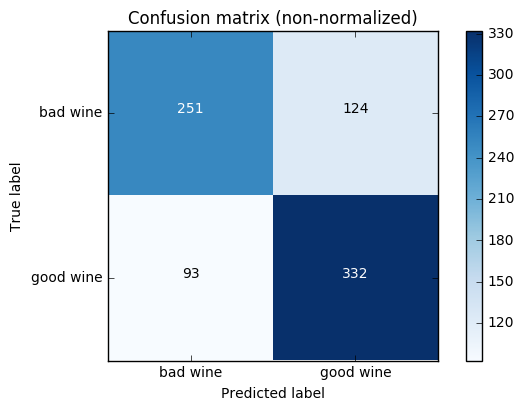

In [448]:
# Compute the predicted values for the test set
y_pred = kNClass_max.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Specify labels for the two classes
class_names = ["bad wine", "good wine"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, \
                      classes = class_names, \
                      title = 'Confusion matrix (non-normalised)')
plt.show()

In [395]:
#ch = pd.concat([pd.DataFrame(y_pred, columns = ["prediction"]), pd.DataFrame(y_test)], axis = 1)
#print(ch.head())

#ch[ch["prediction"] == 0][ch["good wine"] == 1].shape

### Notes

* Redifine the method for data normilisation; take into account the whole dataset
* Clear code and remove unnecessary parts